In [1]:
import numpy as np
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import pandas as pd
import random as random
from calibration_util import *
%matplotlib inline

C:\Users\Caitlin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# generate regression dataset
data = pd.DataFrame()
X1, y1 = make_regression(n_samples=5000, n_features=5, noise=0.2, random_state=99)
g1 = np.zeros(int(len(X1)/2))
g2 = np.ones(int(len(X1)/2))
g = np.append(g1, g2)
d1 = np.insert(X1, 5, values=y1, axis=1)
data = pd.DataFrame(d1)
data = data.sample(frac=1)
data.columns = ['x0','x1','x2','x3','x4','y']
data['g']=g

In [3]:
data.head()

,x0,x1,x2,x3,x4,y,g
201,-1.370487,0.290598,0.635075,-0.158069,0.664065,23.602317,0.0
3122,1.603624,-0.372584,-1.115018,-0.926353,0.025599,-84.604926,0.0
3121,-1.393470,1.452204,-0.510671,1.871288,0.777740,147.390163,0.0
3767,1.827492,0.379022,-1.954776,-1.355027,0.107420,-150.053750,0.0
3590,0.861571,1.297128,1.254345,-1.035902,-0.266977,100.359156,0.0


In [4]:
def scale(data, col):
    data[col] = (data[col]-data[col].min()) / (data[col].max() - data[col].min())

In [5]:
scale(data, 'y')
data.sort_values('y', inplace=True)

In [6]:
data.head()

,x0,x1,x2,x3,x4,y,g
1874,-0.946547,0.582627,-2.433494,-2.509121,-1.244858,0.000000,0.0
3841,-1.511468,-1.897510,-2.280682,-1.926044,-0.545986,0.005904,1.0
3591,-2.950238,-1.165516,-0.964168,-1.904276,-1.040818,0.007851,0.0
1553,-0.030311,-2.056015,-0.752770,-2.526592,-2.351309,0.014097,1.0
1366,-1.519640,-0.034963,-2.009854,-3.097433,0.226367,0.050925,1.0


In [7]:
def under_rank(data):
    
    #randomly select some percentage of group to be under ranked
    data2 = data.copy()
    for i in range(len(data)):
        if(data2.iloc[i]['g'] == 1.):
            if(random.random() <0.25):
                data2.iloc[i]['y'] = data2.iloc[i]['y']*0.5

    data5 = data.copy()
    for i in range(len(data)):
        if(data5.iloc[i]['g'] == 1.):
            if(random.random() <0.5):
                data5.iloc[i]['y'] = data5.iloc[i]['y']*0.5

    data7 = data.copy()
    for i in range(len(data)):
        if(data7.iloc[i]['g'] == 1.):
            if(random.random() <0.75):
                data7.iloc[i]['y'] = data7.iloc[i]['y']*0.5

    data2.sort_values('y', inplace=True)
    data5.sort_values('y', inplace=True)
    data7.sort_values('y', inplace=True)
    
    return data2, data5, data7

In [8]:
def shift_mean(data):
    #shift mean of group by some percentage
    data2 = data.copy()
    for i in range(len(data)):
        if(data2.iloc[i]['g'] == 1.):
                data2.iloc[i]['y'] = data2.iloc[i]['y']-0.25

    data5 = data.copy()
    for i in range(len(data)):
        if(data5.iloc[i]['g'] == 1.):
                data5.iloc[i]['y'] = data5.iloc[i]['y']-0.5

    data7 = data.copy()
    for i in range(len(data)):
        if(data7.iloc[i]['g'] == 1.):
                data7.iloc[i]['y'] = data7.iloc[i]['y']-0.75

    scale(data2, 'y')
    scale(data5, 'y')
    scale(data7, 'y')
    data2.sort_values('y', inplace=True)
    data5.sort_values('y', inplace=True)
    data7.sort_values('y', inplace=True)

    return data2, data5, data7

In [9]:
shift_data2, shift_data5, shift_data7 = shift_mean(data)
under_data2, under_data5, under_data7 = under_rank(data)

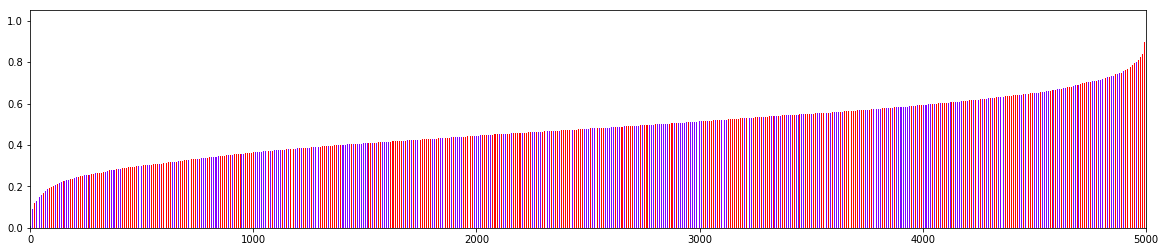

In [10]:
cmap = plt.cm.rainbow
plt.rcParams['figure.figsize'] = (20, 4)
fig, ax = plt.subplots()
ax.bar(range(len(data)), data['y'], 0.5, color=cmap((data['g'])))
ax.set_xlim([0,len(data)])
ax.set_title("", fontsize=16)
plt.show()

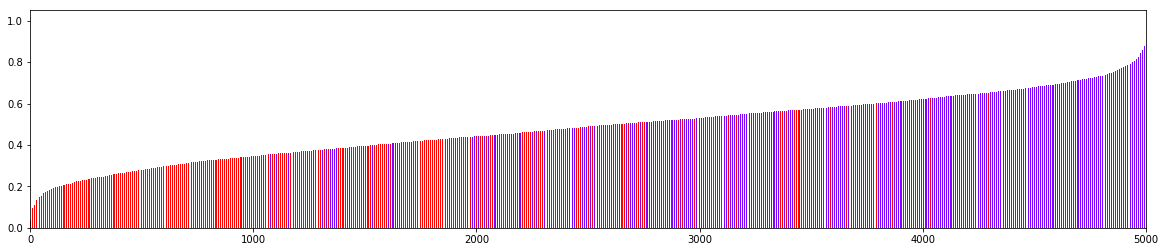

In [11]:
cmap = plt.cm.rainbow
plt.rcParams['figure.figsize'] = (20, 4)
fig, ax = plt.subplots()
ax.bar(range(len(data)), shift_data2['y'], 0.5, color=cmap((shift_data2['g'])))
ax.set_xlim([0,len(data)])
ax.set_title("", fontsize=16)
plt.show()

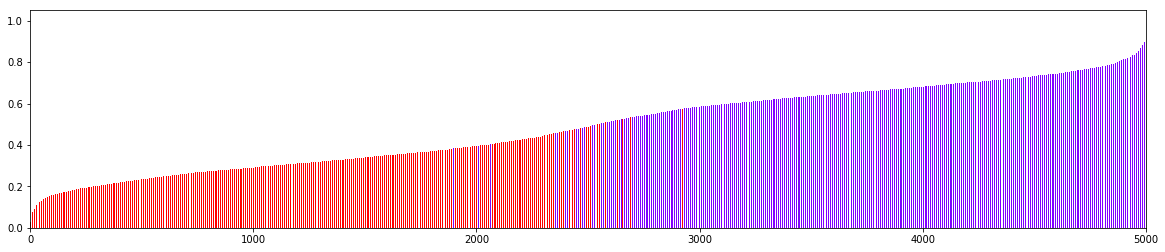

In [12]:
cmap = plt.cm.rainbow
plt.rcParams['figure.figsize'] = (20, 4)
fig, ax = plt.subplots()
ax.bar(range(len(data)), shift_data5['y'], 0.5, color=cmap((shift_data5['g'])))
ax.set_xlim([0,len(data)])
ax.set_title("", fontsize=16)
plt.show()

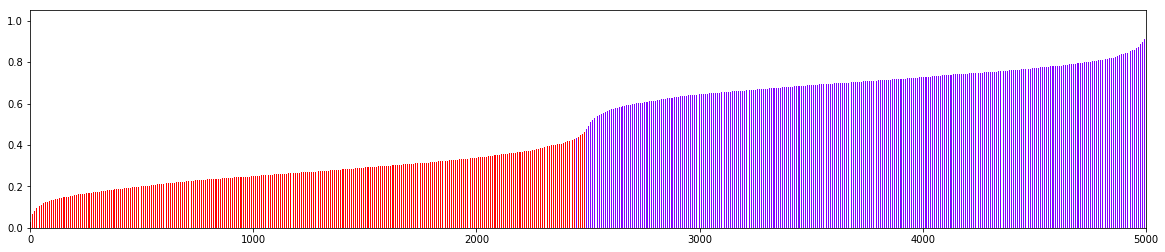

In [13]:
cmap = plt.cm.rainbow
plt.rcParams['figure.figsize'] = (20, 4)
fig, ax = plt.subplots()
ax.bar(range(len(data)), shift_data7['y'], 0.5, color=cmap((shift_data7['g'])))
ax.set_xlim([0,len(data)])
ax.set_title("", fontsize=16)
plt.show()

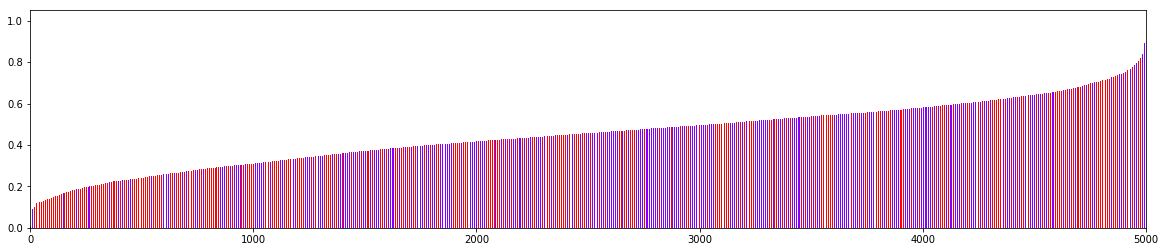

In [14]:
cmap = plt.cm.rainbow
plt.rcParams['figure.figsize'] = (20, 4)
fig, ax = plt.subplots()
ax.bar(range(len(data)), under_data2['y'], 0.5, color=cmap((under_data2['g'])))
ax.set_xlim([0,len(data)])
ax.set_title("", fontsize=16)
plt.show()

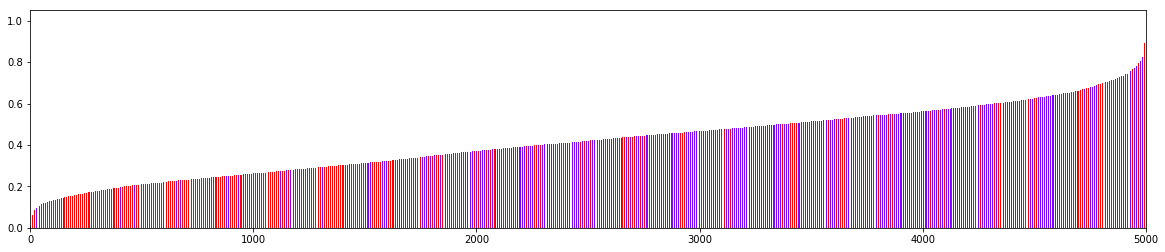

In [15]:
cmap = plt.cm.rainbow
plt.rcParams['figure.figsize'] = (20, 4)
fig, ax = plt.subplots()
ax.bar(range(len(data)), under_data5['y'], 0.5, color=cmap((under_data5['g'])))
ax.set_xlim([0,len(data)])
ax.set_title("", fontsize=16)
plt.show()

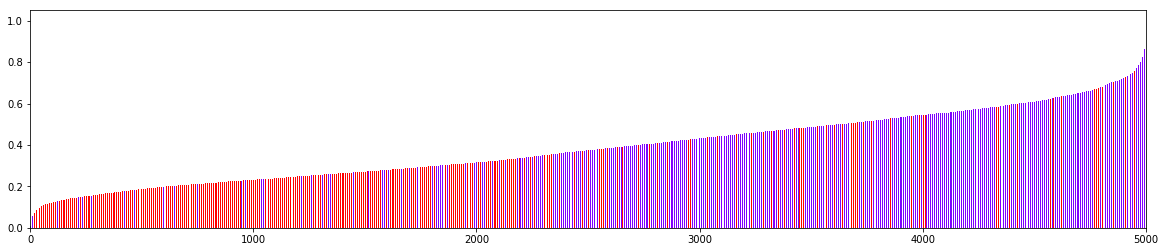

In [16]:
cmap = plt.cm.rainbow
plt.rcParams['figure.figsize'] = (20, 4)
fig, ax = plt.subplots()
ax.bar(range(len(data)), under_data7['y'], 0.5, color=cmap((under_data7['g'])))
ax.set_xlim([0,len(data)])
ax.set_title("", fontsize=16)
plt.show()

In [17]:
df = data[['y','g']]
df['y_pred'] =under_data2['y']

C:\Users\Caitlin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
df.sort_index(inplace=True)
df.head()

C:\Users\Caitlin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,y,g,y_pred
0,0.471193,0.0,0.471193
1,0.598728,1.0,0.598728
2,0.504640,1.0,0.504640
3,0.650549,0.0,0.650549
4,0.364535,0.0,0.364535


In [19]:
def get_calibrated_predictions(train,test):
    
    ir = IsotonicRegression( out_of_bounds = 'clip' )
    ir.fit(train['y_pred'], train['y'])
    
    return ir.transform(test['y_pred'])  
    
def get_groupwise_calibrated_predictions(train, test):
    
    y_pred0 = train[train['g']==0.]['y_pred']
    y_pred1 = train[train['g']==1.]['y_pred']
    y_0 = train[train['g']==0.]['y']
    y_1 = train[train['g']==1.]['y']
    ir0 = IsotonicRegression( out_of_bounds = 'clip' )
    ir0.fit(y_pred0, y_0)
    ir1 = IsotonicRegression( out_of_bounds = 'clip' )
    ir1.fit(y_pred1, y_1)
    
    test0 = test[test['g']==0.]['y_pred']
    test1 = test[test['g']==1.]['y_pred']
    return ir0.transform(test0), ir1.transform(test1)

In [20]:
# 3 fold cross validation,for each split use 25% of the training data for calibration

cv_errors ={}
kf = KFold(n_splits=5, shuffle=True, random_state=1)
i=0
for train_index, test_index in kf.split(df):

    train = df.iloc[train_index]
    test = df.iloc[test_index]
    
    print("training", len(train[train['g']==0.]))
    print("training", len(train[train['g']==1.]))
    print("testing", len(test[test['g']==0.]))
    print("testing", len(test[test['g']==1.]))

    y_pred_baseline = test['y_pred']

    y_pred_cal = get_calibrated_predictions(train, test)
    
    y_pred0, y_pred1 = get_groupwise_calibrated_predictions(train, test)
    y_pred_all = np.append(y_pred0, y_pred1)
    
    y_test0 = test[test['g']==0.]['y']
    y_test1 = test[test['g']==1.]['y']
    y_test_all = np.append(y_test0, y_test1)
        
    g_test0 = test[test['g']==0.]['g']
    g_test1 = test[test['g']==1.]['g']
    g_test_all = np.append(g_test0, g_test1)
    
    y_test = np.array(test['y'])
    g_test = np.array(test['g'])
    
    nbins=5
    baseline_errors = get_errors(y_pred_baseline, y_test, g_test, nbins)
    print("b: ", i)
    calibrate_errors = get_errors(y_pred_cal, y_test, g_test, nbins)
    print("c: ", i)
    cal_by_group_errors = get_errors(y_pred_all, y_test_all, g_test_all, nbins)
    print("cg: ", i)
    
    cv_errors[i] = [baseline_errors, calibrate_errors, cal_by_group_errors]
    i+=1

#     print(get_errors(y_pred_baseline, y_test, g_test, nbins))
#     print(get_errors(y_pred_cal, y_test, g_test, nbins))
#     print(get_errors(y_pred_all, y_test_all, g_test_all, nbins))
    
#     print("Baseline mse: ", mean_squared_error(y_pred_baseline, y_test))
#     print("Calibrate mse: ", mean_squared_error(y_pred_cal, y_test))
#     print("Calibrate by groups mse: ", mean_squared_error(y_pred_all, y_test_all))

#     print("Baseline spearman: ", stats.spearmanr(y_pred_baseline, y_test))
#     print("Calibrate spearman: ", stats.spearmanr(y_pred_cal, y_test))
#     print("Calibrate by groups spearman: ", stats.spearmanr(y_pred_all, y_test_all))
    

training 1987
training 2013
testing 513
testing 487
b:  0
c:  0
cg:  0
training 2014
training 1986
testing 486
testing 514
b:  1
c:  1
cg:  1
training 1998
training 2002
testing 502
testing 498
b:  2
c:  2
cg:  2
training 2004
training 1996
testing 496
testing 504
b:  3
c:  3
cg:  3
training 1997
training 2003
testing 503
testing 497
b:  4
c:  4
cg:  4


In [21]:
b = pd.concat([cv_errors[0][0][['bin_mse_diff','bin_oe_diff','bin_ue_diff', 'bin_spear_diff']].abs().sum(),
           cv_errors[1][0][['bin_mse_diff','bin_oe_diff','bin_ue_diff', 'bin_spear_diff']].abs().sum(),
           cv_errors[2][0][['bin_mse_diff','bin_oe_diff','bin_ue_diff', 'bin_spear_diff']].abs().sum()], axis=1).transpose()
c = pd.concat([cv_errors[0][1][['bin_mse_diff','bin_oe_diff','bin_ue_diff', 'bin_spear_diff']].abs().sum(),
           cv_errors[1][1][['bin_mse_diff','bin_oe_diff','bin_ue_diff', 'bin_spear_diff']].abs().sum(),
           cv_errors[2][1][['bin_mse_diff','bin_oe_diff','bin_ue_diff', 'bin_spear_diff']].abs().sum()], axis=1).transpose()
cg = pd.concat([cv_errors[0][2][['bin_mse_diff','bin_oe_diff','bin_ue_diff', 'bin_spear_diff']].abs().sum(),
           cv_errors[1][2][['bin_mse_diff','bin_oe_diff','bin_ue_diff', 'bin_spear_diff']].abs().sum(),
           cv_errors[2][2][['bin_mse_diff','bin_oe_diff','bin_ue_diff', 'bin_spear_diff']].abs().sum()], axis=1).transpose()

In [22]:
b.sum()

bin_mse_diff       0.214147
bin_oe_diff        0.000000
bin_ue_diff       82.960372
bin_spear_diff     3.884270
dtype: float64

In [23]:
c.sum()

bin_mse_diff       0.093093
bin_oe_diff        5.014658
bin_ue_diff       48.105956
bin_spear_diff     3.897433
dtype: float64

In [24]:
cg.sum()

bin_mse_diff       0.104965
bin_oe_diff       35.435897
bin_ue_diff       36.268095
bin_spear_diff     3.780962
dtype: float64